<a href="https://colab.research.google.com/github/aliakbarbadri/natural-language-inference/blob/master/seq2seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
import tensorflow_addons as tfa

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, GRU, TimeDistributed
import unicodedata
import re
import numpy as np
import os
import io
import time
import pandas as pd
import numpy as np
import string
from string import digits
import matplotlib.pyplot as plt
%matplotlib inline
import re
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.layers import Input, LSTM, Embedding, Dense
from keras.models import Model

Using TensorFlow backend.


# Load and Preprocess the data

In [2]:
source = pd.read_pickle(r'https://github.com/aliakbarbadri/natural-language-inference/blob/master/hypotheses_train.pickle?raw=true')
target = pd.read_pickle(r'https://github.com/aliakbarbadri/natural-language-inference/blob/master/premises_train.pickle?raw=true')

In [3]:
print(source[0])
print(target[0])

A person is outdoors , on a horse .
A person on a horse jumps over a broken down airplane .


In [4]:
lines_main = pd.DataFrame(
    {'source': source,
     'target': target
     })

In [5]:
lines_main.shape

(183416, 2)

In [6]:
lines = lines_main[:50000]

In [7]:
lines.shape

(50000, 2)

In [8]:
# Lowercase all characters
lines.source=lines.source.apply(lambda x: x.lower())
lines.target=lines.target.apply(lambda x: x.lower())

# Remove quotes
lines.source=lines.source.apply(lambda x: re.sub("'", '', x))
lines.target=lines.target.apply(lambda x: re.sub("'", '', x))

exclude = set(string.punctuation) # Set of all special characters
# Remove all the special characters
lines.source=lines.source.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
lines.target=lines.target.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))

# Remove all numbers from text
remove_digits = str.maketrans('', '', digits)
lines.source=lines.source.apply(lambda x: x.translate(remove_digits))
lines.target=lines.target.apply(lambda x: x.translate(remove_digits))

# Remove extra spaces
lines.source=lines.source.apply(lambda x: x.strip())
lines.target=lines.target.apply(lambda x: x.strip())
lines.source=lines.source.apply(lambda x: re.sub(" +", " ", x))
lines.target=lines.target.apply(lambda x: re.sub(" +", " ", x))

# Add start and end tokens to target sequences
lines.target = lines.target.apply(lambda x : 'START_ '+ x + ' _END')

lines.sample(10)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,source,target
31711,people riding a scooter,START_ a man and woman are riding a motor scoo...
20731,the man is outside of a restaurant,START_ a man is walking by a large outdoor pla...
11433,there are elderly men reading,START_ older men are sitting in chairs reading...
44613,the rugby game was very physical,START_ a rugby game being played one man in a ...
23404,a woman is sitting outside,START_ a woman in a red shirt is sitting on th...
380,the boy is wearing a shirt,START_ a boy in a blue yellow and orange shirt...
31326,a child sleeping in a stroller,START_ a young child leaning forward asleep in...
5585,a boy and father play,START_ little boy playing with his daddy by th...
37436,the man is focusing on something in front of him,START_ a man looks straight ahead at night _END
24488,a person is using his skateboard near a ramp,START_ a boy skateboards off a ramp covered in...


In [9]:
all_words_source=set()
for line in lines.source:
    for word in line.split():
        if word not in all_words_source:
            all_words_source.add(word)

all_words_target=set()
for line in lines.target:
    for word in line.split():
        if word not in all_words_target:
            all_words_target.add(word)

In [10]:
lenght_list=[]
for l in lines.source:
    lenght_list.append(len(l.split(' ')))
max_length_src = np.max(lenght_list)

lenght_list=[]
for l in lines.target:
    lenght_list.append(len(l.split(' ')))
max_length_tar = np.max(lenght_list)

max_length_src, max_length_tar

(43, 80)

In [11]:
input_words = sorted(list(all_words_source))
target_words = sorted(list(all_words_target))

num_encoder_tokens = len(all_words_source)
num_decoder_tokens = len(all_words_target)

num_encoder_tokens, num_decoder_tokens

(8691, 11412)

In [12]:
num_decoder_tokens += 1 # For zero padding
num_decoder_tokens

11413

In [13]:
input_token_index = dict([(word, i+1) for i, word in enumerate(input_words)])
target_token_index = dict([(word, i+1) for i, word in enumerate(target_words)])

In [14]:
reverse_input_char_index = dict((i, word) for word, i in input_token_index.items())
reverse_target_char_index = dict((i, word) for word, i in target_token_index.items())

In [15]:
lines = shuffle(lines)
lines.head(10)

,source,target
19023,three women leaning against a metal fence,START_ three brownhaired women in brown and gr...
23342,two men in a karate match,START_ there are two men engaged in a karate m...
34646,the man is pointing to something,START_ man holding his index finger in front o...
35247,the man is in a white shirt,START_ a man in a shortsleeved white shirt is ...
47083,a man and woman sit atop a wall and watch a wa...,START_ a man and two women are seated outside ...
19941,a women is standing outdoors,START_ a woman wearing a blue jacket is standi...
13828,a young lady is wearing bright pink lenses and...,START_ a young lady is wearing bright pink sun...
27295,a man leans against a ledge while a man stands...,START_ a man in a yellow hard hat leans agains...
5432,a race car is present,START_ red bullbranded race car leaves smoke b...
49659,the dog s mouth is on the soccer ball,START_ a black dog is biting onto a soccer bal...


In [16]:
# Train - Test Split
X, y = lines.source, lines.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
X_train.shape, X_test.shape

((40000,), (10000,))

In [17]:
X_train.to_pickle('X_train.pkl')
X_test.to_pickle('X_test.pkl')

In [18]:
def generate_batch(X = X_train, y = y_train, batch_size = 64):
    ''' Generate a batch of data '''
    while True:
        for j in range(0, len(X), batch_size):
            encoder_input_data = np.zeros((batch_size, max_length_src),dtype='float32')
            decoder_input_data = np.zeros((batch_size, max_length_tar),dtype='float32')
            decoder_target_data = np.zeros((batch_size, max_length_tar, num_decoder_tokens),dtype='float32')
            for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):
                for t, word in enumerate(input_text.split()):
                    encoder_input_data[i, t] = input_token_index[word] # encoder input seq
                for t, word in enumerate(target_text.split()):
                    if t<len(target_text.split())-1:
                        decoder_input_data[i, t] = target_token_index[word] # decoder input seq
                    if t>0:
                        # decoder target sequence (one hot encoded)
                        # does not include the START_ token
                        # Offset by one timestep
                        decoder_target_data[i, t - 1, target_token_index[word]] = 1.
            yield([encoder_input_data, decoder_input_data], decoder_target_data)

# Model

In [31]:
latent_dim = 50

In [42]:
encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(num_encoder_tokens, latent_dim, mask_zero = True)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
encoder_states = [state_h, state_c]

In [43]:
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(num_decoder_tokens, latent_dim, mask_zero = True)
dec_emb = dec_emb_layer(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [44]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

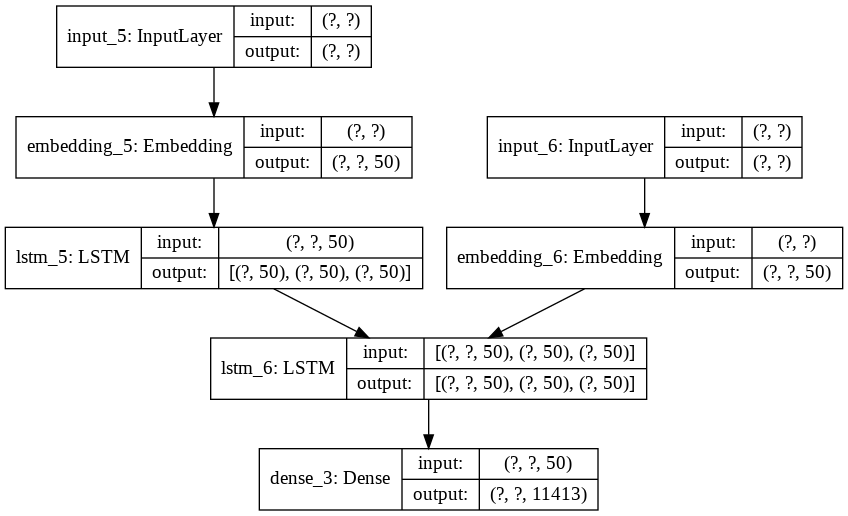

In [45]:
keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True)

In [46]:
train_samples = len(X_train)
val_samples = len(X_test)
batch_size = 32
epochs = 10

In [47]:
import os

In [53]:
history = model.fit_generator(generator = generate_batch(X_train, y_train, batch_size = batch_size),
                    steps_per_epoch = train_samples//batch_size,
                    epochs=epochs,
                    validation_data = generate_batch(X_test, y_test, batch_size = batch_size),
                    validation_steps = val_samples//batch_size)

Epoch 1/30
1250/1250 [==============================] - 481s 385ms/step - loss: 0.7084 - acc: 0.3130 - val_loss: 0.8062 - val_acc: 0.3254
Epoch 2/30
1250/1250 [==============================] - 489s 391ms/step - loss: 0.6859 - acc: 0.3318 - val_loss: 0.7273 - val_acc: 0.3364
Epoch 3/30
1250/1250 [==============================] - 488s 391ms/step - loss: 0.6717 - acc: 0.3412 - val_loss: 0.6873 - val_acc: 0.3434
Epoch 4/30
1250/1250 [==============================] - 491s 393ms/step - loss: 0.6606 - acc: 0.3493 - val_loss: 0.8672 - val_acc: 0.3496
Epoch 5/30
1250/1250 [==============================] - 488s 390ms/step - loss: 0.6505 - acc: 0.3567 - val_loss: 0.7106 - val_acc: 0.3545
Epoch 6/30
1250/1250 [==============================] - 482s 386ms/step - loss: 0.6414 - acc: 0.3633 - val_loss: 0.6715 - val_acc: 0.3587
Epoch 7/30
1250/1250 [==============================] - 478s 382ms/step - loss: 0.6358 - acc: 0.3687 - val_loss: 0.6662 - val_acc: 0.3623
Epoch 8/30
1250/1250 [============

KeyboardInterrupt: ignored

In [ ]:
model = keras.models.load_model('seq2seq_model.h5')

In [49]:
model.save('seq2seq_model.h5')

# Loss and Acc. graph

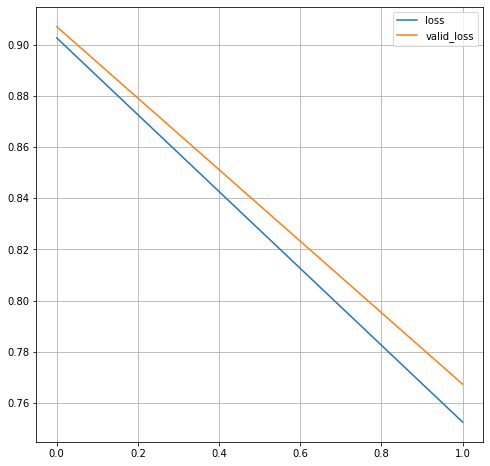

In [54]:
pd.DataFrame({'loss':history.history['loss'],
              'valid_loss':history.history['val_loss'],
              }).plot(figsize=(8, 8))
plt.grid(True)

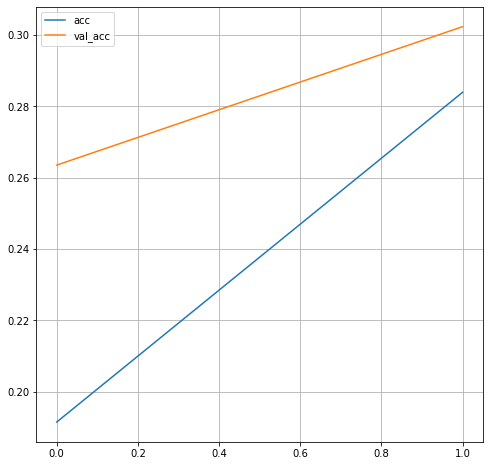

In [55]:
pd.DataFrame({'acc':history.history['acc'],
              'val_acc':history.history['val_acc']
              }).plot(figsize=(8, 8))
plt.grid(True)


# Model Evaluation

In [63]:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2= dec_emb_layer(decoder_inputs)

decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2)

decoder_model = Model([decoder_inputs] + decoder_states_inputs,
                      [decoder_outputs2] + decoder_states2)

In [64]:
def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = target_token_index['START_']
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += ' '+sampled_char
        if (sampled_char == '_END' or
           len(decoded_sentence) > 50):
            stop_condition = True
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        states_value = [h, c]
    return decoded_sentence

In [65]:
test_gen = generate_batch(X_test, y_test, batch_size = 1)
k=-1

In [66]:
k+=1
(input_seq, actual_output), _ = next(test_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input:', X_test[k:k+1].values[0])
print('Actual:', y_test[k:k+1].values[0][6:-4])
print('Predicted:', decoded_sentence[:-4])

Input: a man is getting help with fitness
Actual:  a man getting help with fitness from a physical trainer in a gym 
Predicted:  a man in a white shirt is working on a stage 


In [67]:
print(y_test[k:k+1].values[0])
print(y_test[k:k+1].values[0][6:-4])
print()
print(decoded_sentence)
print(decoded_sentence[:-4])

START_ a man getting help with fitness from a physical trainer in a gym _END
 a man getting help with fitness from a physical trainer in a gym 

 a man in a white shirt is working on a stage _END
 a man in a white shirt is working on a stage 


# Blue

https://towardsdatascience.com/evaluating-text-output-in-nlp-bleu-at-your-own-risk-e8609665a213

# 